In [18]:
from mesa.batchrunner import BatchRunnerMP
import matplotlib.pyplot as plt
import pandas, pickle
from nice_bison.model import NiceBison
from SALib.analyze import sobol
from SALib.sample import saltelli
import numpy as np
from IPython.display import clear_output
from itertools import combinations
import pickle

## One factor at a time

In [37]:
file_name = 'sa_r2_m500_d8'

problem = {
    'num_vars': 11,
    'names': ['initial_bison', 'initial_bison_food', 'bison_reproduce_threshold',
              'amount_grass_growth', 'number_grass_growth', 'initial_bison_cooperation_std',
              'mutation_std', 'battle_cost', 'grass_spread', 
              'movement_weight_fights', 'sight'],
    'bounds': [[5, 30], [1, 8], [5, 15], [2, 10], [2, 10], [0.01, 0.5], [0.01, 0.5], [0.0, 1.0], [0.5, 5], [0, 1], [1, 6]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 2
max_steps = 500
distinct_samples = 6

# Set the outputs
model_reporters = {'Altruism (avg)': lambda m: m.schedule.get_average_cooperation_of_run(),
                   'Altruism (std)': lambda m: m.schedule.get_std_cooperation_of_run()}

data = {}

int_vars = ['initial_bison', 'initial_bison_food', 'bison_reproduce_threshold',
              'amount_grass_growth', 'number_grass_growth', 'sight']

In [38]:
for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    # Keep in mind that wolf_gain_from_food should be integers. You will have to change
    # your code to acommidate for this or sample in such a way that you only get integers.
    if var in int_vars:
        samples = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)
    
    batch = BatchRunnerMP(NiceBison,
                          4,
                          max_steps=max_steps,
                          iterations=replicates,
                          variable_parameters={var: samples},
                          model_reporters=model_reporters,
                          display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()

with open(f'data/{file_name}_ofat.pickle', 'wb') as file:
    pickle.dump(data, file)

12it [00:04,  2.57it/s]
12it [00:04,  2.55it/s]
12it [00:04,  2.55it/s]
12it [00:05,  2.21it/s]
12it [00:04,  2.42it/s]
12it [00:04,  2.66it/s]
12it [00:04,  2.66it/s]
12it [00:04,  2.43it/s]
12it [00:04,  2.47it/s]
12it [00:05,  2.01it/s]
12it [00:05,  2.32it/s]


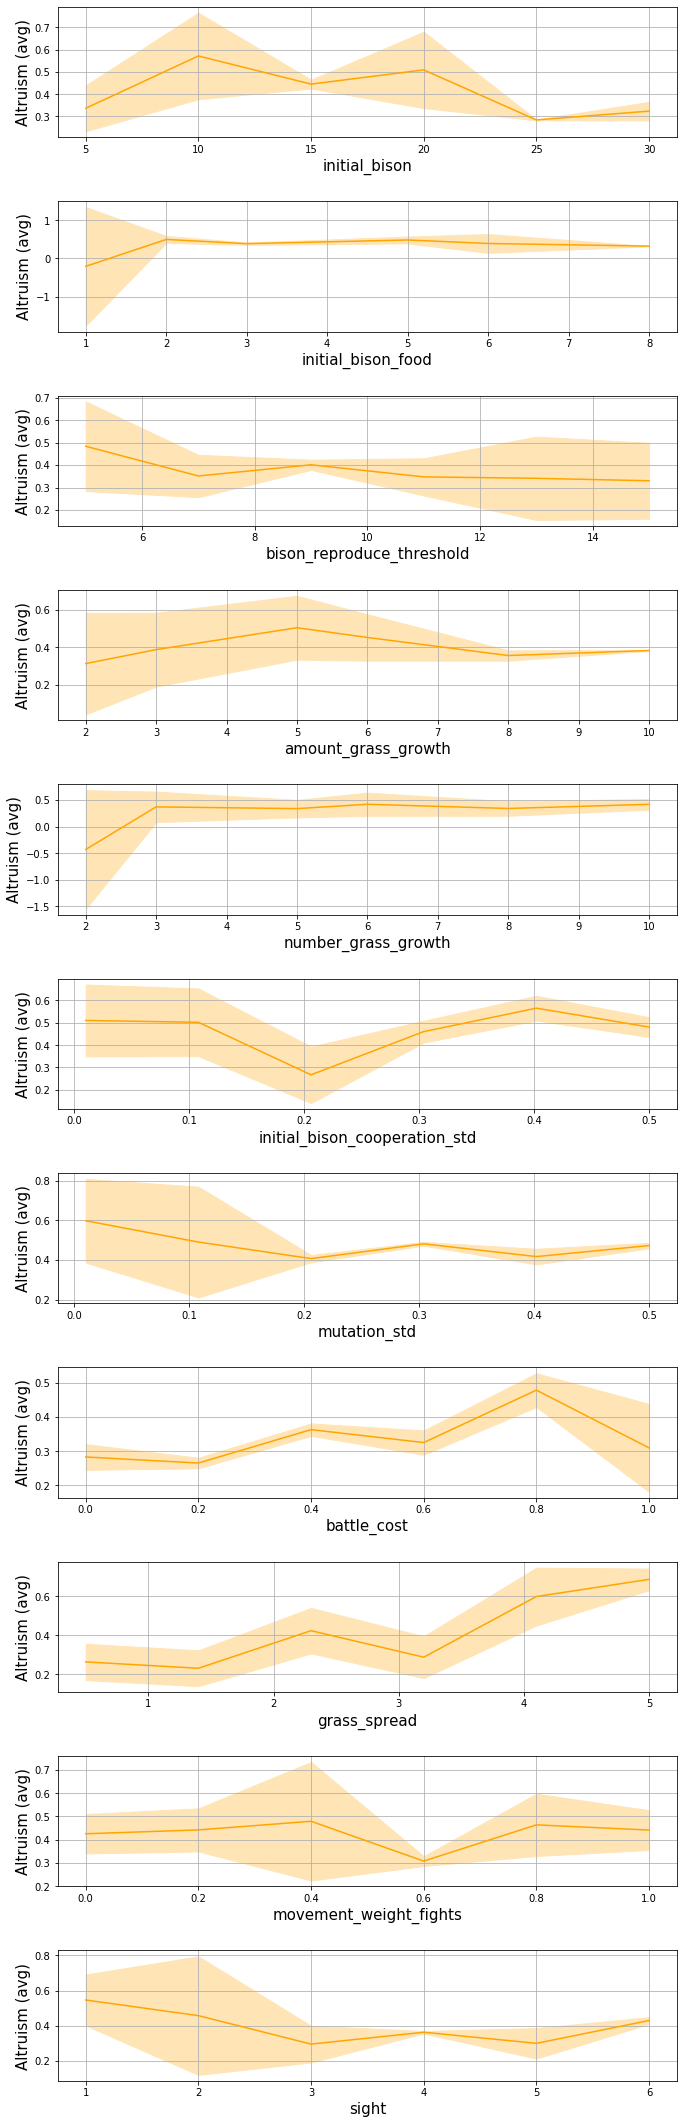

In [39]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, color='orange')
    ax.fill_between(x, y - err, y + err, color='moccasin')
    ax.grid()

    ax.set_xlabel(var, fontsize=15)
    ax.set_ylabel(param, fontsize=15)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(problem['num_vars'], figsize=(10, 30))
    
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], data[var], var, param, i)
        
    f.tight_layout(pad=2.5)

plot_all_vars(data, 'Altruism (avg)')

## Sobol SA

In [40]:
sobol_problem = {
    'num_vars': 5,
    'names': ['mutation_std', 'battle_cost', 'grass_spread', 
              'movement_weight_fights', 'sight'],
    'bounds': [[0.01, 0.5], [0, 2], [0.5, 5], [0, 1], [1, 8]]
}

param_values = saltelli.sample(sobol_problem, distinct_samples)

In [ ]:
batch = BatchRunnerMP(NiceBison, 
                      4,
                      max_steps=max_steps,
                      variable_parameters={name:[] for name in sobol_problem['names']},
                      model_reporters=model_reporters)

count = 0
for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        for i in range(len(vals)):
            if vals[i] in int_vars:
                vals[i] = int(vals[i])

        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(sobol_problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
    
data = batch.get_model_vars_dataframe()
with open(f'data/{file_name}_sobol.pickle', 'wb') as file:
    pickle.dump(data, file)

In [12]:
data

,mutation_std,battle_cost,grass_spread,movement_weight_fights,sight,Run,altruism_avg,altruism_std
0,0.117666,0.193359,2.833496,0.676758,2.961914,0,0.263518,0.186573
1,0.454541,0.193359,2.833496,0.676758,2.961914,1,0.342719,0.269493
2,0.117666,0.091797,2.833496,0.676758,2.961914,2,0.275871,0.195380
3,0.117666,0.193359,4.547363,0.676758,2.961914,3,0.477353,0.258733
4,0.117666,0.193359,2.833496,0.500977,2.961914,4,0.362628,0.222908
...,...,...,...,...,...,...,...,...
139,0.148291,1.943359,2.859863,0.875977,2.360352,139,0.674564,0.233356
140,0.148291,1.841797,3.395996,0.875977,2.360352,140,0.609664,0.251148
141,0.148291,1.841797,2.859863,0.801758,2.360352,141,0.504035,0.268621
142,0.148291,1.841797,2.859863,0.875977,5.586914,142,0.539597,0.238715


In [14]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

Parameter S1 S1_conf ST ST_conf
mutation_std -0.355473 1.027537 0.747271 0.472264
battle_cost -1.655139 2.631063 6.511974 11.540661
grass_spread 0.450933 0.309688 0.435269 0.566076
movement_weight_fights 0.033029 0.337211 0.137730 0.114615
sight -0.389436 0.303634 0.197105 0.163023

Parameter_1 Parameter_2 S2 S2_conf
mutation_std battle_cost 0.900163 1.923445
mutation_std grass_spread -0.835263 3.007635
mutation_std movement_weight_fights 0.082537 1.361229
mutation_std sight 0.423287 1.619451
battle_cost grass_spread 1.596762 2.797650
battle_cost movement_weight_fights 1.793295 2.751084
battle_cost sight 1.710111 2.685181
grass_spread movement_weight_fights -0.281645 0.457864
grass_spread sight -0.053713 0.319002
movement_weight_fights sight 0.003971 0.427169


/Users/jurrew27/anaconda3/envs/abm/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


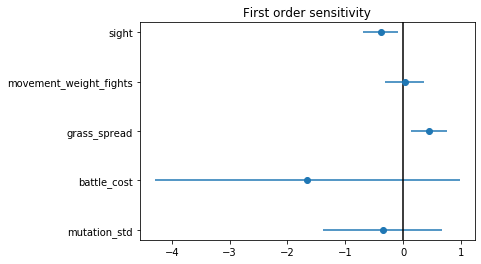

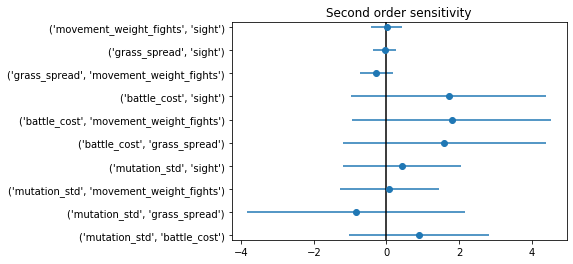

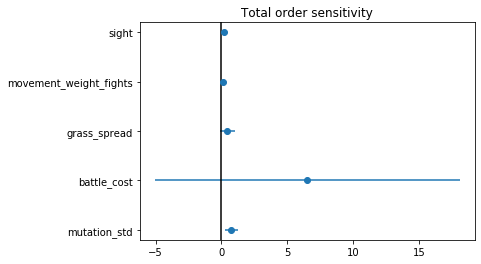

In [19]:
Si = sobol.analyze(sobol_problem, data['altruism_avg'].as_matrix(), print_to_console=True)

# First order
plot_index(Si, sobol_problem['names'], '1', 'First order sensitivity')
plt.show()

# Second order
plot_index(Si, sobol_problem['names'], '2', 'Second order sensitivity')
plt.show()

# Total order
plot_index(Si, sobol_problem['names'], 'T', 'Total order sensitivity')
plt.show()